# Peptide Level Data Processing for Neuroblastoma Analysis

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

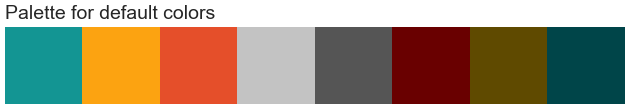

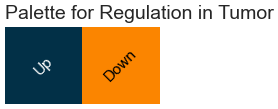

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

# plots.color_palette(
#     status_colors,
#     name="Status",
#     save=False
# )

plots.color_palette(
    regulation_colors,
    name="Regulation in Tumor",
    save=False
)

In [3]:
notebook_name = "2_processing"
data_path = "./data/prepared/"
output_path = f"./data/processed/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load Data

### Peptide Level

In [4]:
data = feather.read_dataframe(f"{data_path}NBL_directDIA_May2024.feather")
info_data = data.iloc[:, :10]
# info_data = info_data.set_index("Protein")
quan_data = data.iloc[:, 10:]

# Set the values lower than 8 (lloq) to NaN
quan_data[quan_data <= 8] = np.nan

print("Number of unique proteins:", info_data["Protein"].nunique())
print("Number of unique peptides:", info_data.shape[0])
print()
utils.print_shape(info_data, "Info")
utils.print_shape(quan_data, "Quant")

info_data.head()

Number of unique proteins: 11560
Number of unique peptides: 203868

Info data has 203,868 rows and 10 columns
Quant data has 203,868 rows and 122 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False
1,A0A024RBG1,FKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,3,10,181,1,23.7569,False
2,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False
3,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False
4,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False


### Get the Protein Info from Peptide Level

In [5]:
protein_info = info_data[[
    "Protein", "geneName", "proteinDescription", "isCAP", "seqLength", "Cov%"
]].drop_duplicates().set_index("Protein")
protein_info['nPeps_init'] = info_data.groupby("Protein").size()

utils.print_shape(protein_info, "Protein Info")
protein_info.head()

Protein Info data has 11,560 rows and 6 columns


,geneName,proteinDescription,isCAP,seqLength,Cov%,nPeps_init
Protein,,,,,,
A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,False,181,23.7569,6
A0A075B6I0,IGLV8-61,Immunoglobulin lambda variable 8-61,False,122,20.4918,3
A0A075B6J1,IGLV5-37,Immunoglobulin lambda variable 5-37,False,123,16.2602,2
A0A075B6J9,IGLV2-18,Immunoglobulin lambda variable 2-18,False,118,24.5763,2
A0A075B6K0,IGLV3-16,Immunoglobulin lambda variable 3-16,False,115,8.6957,1


### Metadata

In [6]:
metadata = pd.read_csv(f"{data_path}NBL_directDIA_May2024_metadata.csv")
print("Number of marked samples in metadata:", metadata["Info"].sum())
utils.print_shape(metadata, "Metadata")
print()
utils.print_series(metadata["Location"].value_counts(), "Number of samples per location")
metadata.head()

Number of marked samples in metadata: 26
Metadata data has 122 rows and 15 columns

Number of samples per location
 retroperitoneal -> 52
 mediastinum -> 14
 BM -> 12
 AG -> 11
 LN, cervical -> 5
 soft tissue -> 3
 LN, Neck -> 3
 skeletal muscle -> 2
 liver -> 2
 GNBI -> 2
 NB -> 2
 dorsal root ganglion -> 1
 bladder -> 1
 LN, abdomen -> 1
 brain -> 1
 thigh -> 1
 Nerve -> 1
 abdomen -> 1
 ganglion -> 1
 skin -> 1


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
0,[122] 20240321_GB_NBL-macro-1_Slot1-51_1_485.h...,20240321,NBL-macro-1,Slot1-51,NBL-macro-1_Slot1-51,1.0000,1.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
1,[110] 20240320_GB_NBL-macro-2_Slot1-35_1_467.h...,20240320,NBL-macro-2,Slot1-35,NBL-macro-2_Slot1-35,2.0000,2.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
2,[123] 20240321_GB_NBL-macro-3_Slot1-52_1_486.h...,20240321,NBL-macro-3,Slot1-52,NBL-macro-3_Slot1-52,3.0000,3.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
3,[124] 20240321_GB_NBL-macro-4_Slot1-53_1_487.h...,20240321,NBL-macro-4,Slot1-53,NBL-macro-4_Slot1-53,4.0000,4.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
4,[125] 20240321_GB_NBL-macro-5_Slot1-39_1_472.h...,20240321,NBL-macro-5,Slot1-39,NBL-macro-5_Slot1-39,5.0000,5.0000,Tumor,Diff,Low,FH,Not Amp,mediastinum,NaN,False


# Paired Normal-Tumor Patient Samples for Analysis

They are mostly tumor at retroperitoneal and normal at adrenal gland. I tried to keep the same patient for normal and tumor samples as much as possible for the first application.

## Subset for the Paired Samples 

In [7]:
# Specific subset from the metadata for the Paired Tumor vs Normal Samples
subset_to_run = metadata[
    metadata["Info"]
].sort_values(
    ["Group", "ID"], 
    ascending=[True, True]
)

utils.print_series(subset_to_run["Group"].value_counts(), "Status")
print()
utils.print_series(subset_to_run["Location"].value_counts(), "Disease Location")
print()
print("Selecting Matching Patient Samples originatign from AG (Normal) Retroperitoneal (Tumor) samples for the analysis.")
subset_to_run = subset_to_run[subset_to_run["Location"].isin(["AG", "retroperitoneal"])]

# Create Group: [UniqueNames] dictionary
subset_to_run_dict = subset_to_run.groupby("Group")["UniqueNames"].apply(list).to_dict()
# Create UniqueNames: Group dictionary
unique_group_dict = subset_to_run.set_index("UniqueNames")["Group"].to_dict()   
# Sample colors
sample_colors = {
    k: status_colors[v] for k, v in unique_group_dict.items()
}

new_status_dict = {
    "Tumor": subset_to_run[subset_to_run["Group"] == "Tumor"]["UniqueNames"].values.tolist(),
    "Normal": subset_to_run[subset_to_run["Group"] == "Normal"]["UniqueNames"].values.tolist(),
}

# Create subsets
info_subset = info_data.copy()
quan_subset = quan_data[
    subset_to_run["UniqueNames"]
].copy()

print("Number of unique proteins:", info_subset["Protein"].nunique())
print("Number of unique peptides:", info_subset.shape[0])

Status
 Normal -> 14
 Tumor -> 12

Disease Location
 AG -> 10
 retroperitoneal -> 10
 skeletal muscle -> 2
 dorsal root ganglion -> 1
 ganglion -> 1
 soft tissue -> 1
 thigh -> 1

Selecting Matching Patient Samples originatign from AG (Normal) Retroperitoneal (Tumor) samples for the analysis.
Number of unique proteins: 11560
Number of unique peptides: 203868


In [8]:
subset_to_run.to_csv(f"{output_path}NBL_directDIA_May2024_metadata_subset.csv", index=False)

The specific subset of AG and retroperitoneal samples are selected for the analysis. Since they would indicate the minimal difference betweeen biological samples.

## Initial Quality Check of the Subset

### Sample Distribution

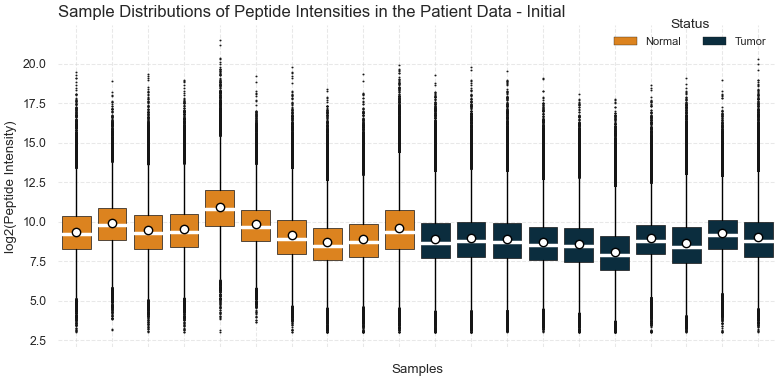

In [9]:
plot_data = np.log2(quan_subset).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    subset_to_run[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Peptide Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Peptide Intensities in the Patient Data - Initial", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Initial_PairedSamples_StatusLabeled_DistributionBoxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

# Data Processing 

The data processing will be very specific for this data and the analysis that we are going to do. The main steps are:

1. **Filtering:** 
    - Remove peptides that are missing in all samples
2. **Imputation:** 
    - Impute missing values with the minimum value of the peptide
3. **Normalization:**
    - Normalize the data by the median of the peptide


## Cleaning 

### Recover the Absence for Proteoform Identification

The first step is to clean the sparsely quantified in each group of peptides if lower than 3 samples per group (with 10 sample) is quantified then I amputate them this enables fully imputing that peptide with low values without any bias. If more than 7 samples are quantified then I will impute the missing samples with the median of those 7+ samples.



In [10]:
# minimum number of peptides per sample 
minRep = 0
cleaned_data = quan_subset.copy()
totalMiss = cleaned_data.isna().sum().sum()

print(f"Number of samples:", cleaned_data.shape[1])
print(f"Number of peptides:", cleaned_data.shape[0])
print()

print("Cleaning single quantified peptides in sample per group.")
print(f"Number of missing values in the dataset: {totalMiss}")
print(f"Percentage of missing values in the dataset: {(totalMiss / cleaned_data.size) * 100:.2f}%")
print()

# Amputate the peptides with less than minRep quantified samples in a group
print(f"Amputating peptides with less than {minRep} quantified samples in a group.")
for k, v in new_status_dict.items():
    amputeIdx = np.where(cleaned_data[v].notna().sum(axis=1) <= minRep)[0]
    cleaned_data.loc[amputeIdx, v] = np.nan

updatedTotalMiss = cleaned_data.isna().sum().sum()
print(f"Number of missing values in the dataset: {updatedTotalMiss}")
print(f"Percentage of missing values in the dataset: {(updatedTotalMiss / cleaned_data.size) * 100:.2f}%")

Number of samples: 20
Number of peptides: 203868

Cleaning single quantified peptides in sample per group.
Number of missing values in the dataset: 2954240
Percentage of missing values in the dataset: 72.45%

Amputating peptides with less than 0 quantified samples in a group.
Number of missing values in the dataset: 2954240
Percentage of missing values in the dataset: 72.45%


In [11]:
## Imputing
# Number of quantified samples to be considered for imputation 
maxRep = 5 
method = "mean" # Imputation method
cleaned_data_2 = np.log2(cleaned_data).copy()
totalMiss = cleaned_data_2.isna().sum().sum()

print(f"Number of missing values in the dataset: {totalMiss}")
print(f"Percentage of missing values in the dataset: {totalMiss / cleaned_data_2.size * 100:.2f}%")
print()

print(f"Completing sparsely missing peptides (Quantified > {maxRep} reps) with {method} imputation.")

for k, v in new_status_dict.items():
    # Find the peptides with more than maxRep quantified samples
    completeIdx = (cleaned_data_2[v].notna().sum(axis=1) >= maxRep) & (cleaned_data_2[v].isna().sum(axis=1) > 0)
    
    # Impute the missing values with the median or mean
    if method == "median":
        imputed_values = cleaned_data_2[v].apply(lambda x: x.fillna(x.median()), axis=1)
    elif method == "mean":
        imputed_values = cleaned_data_2[v].apply(lambda x: x.fillna(x.mean()), axis=1)
    
    cleaned_data_2.loc[completeIdx, v] = imputed_values.loc[completeIdx]

updatedTotalMiss = cleaned_data_2.isna().sum().sum()
print(f"Number of missing values in the dataset: {updatedTotalMiss}")
print(f"Percentage of missing values in the dataset: {updatedTotalMiss / cleaned_data_2.size * 100:.2f}%")

cleaned_data = cleaned_data_2.copy()
cleaned_data = 2**cleaned_data

Number of missing values in the dataset: 2954240
Percentage of missing values in the dataset: 72.45%

Completing sparsely missing peptides (Quantified > 5 reps) with mean imputation.
Number of missing values in the dataset: 2694936
Percentage of missing values in the dataset: 66.10%


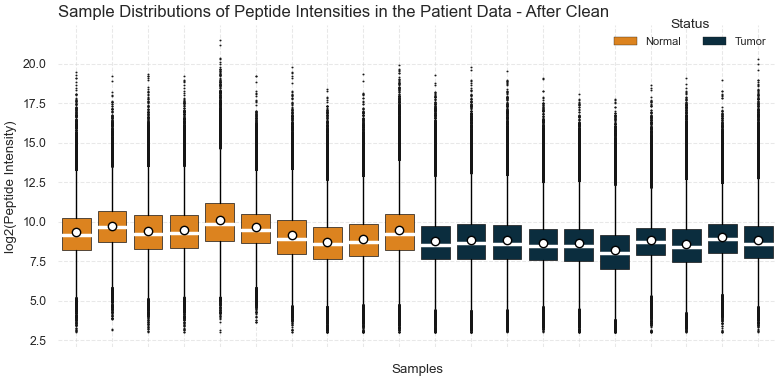

In [12]:
plot_data = np.log2(cleaned_data).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    subset_to_run[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Peptide Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Peptide Intensities in the Patient Data - After Clean", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()

## Filtering

### Remove Fully and Mostly Missing in Both Peptides

From the earlier check, we have seen quite a few peptides that are mostly missing in both tumor and normal samples and there are some instance of fully missing peptides. This is due to the subsetted samples don't have the quantification for those peptides. We will remove those peptides from the analysis.

**Peptide Quantification Status Comparison**

Generally when we look at missingness or quantification status, we use various ways to represent missingness; such as per sample, per analyte etc. However for this particular data and the analysis that we are going to do, we are interested in the quantification status of the peptides grouped by different status labels. Here are the status labels and their definitions:

- Fully Quantified: Peptides that are quantified in all samples
- Mostly Quantified in Both: Peptides that are quantified in both (tumor and normal) with mostly quantified is defined as at least 75% of the samples are quantified
- Fully Missing: Peptides that are missing in all samples
- Mostly Missing in Both: Peptides that are missing in both (tumor and normal) with mostly missing is defined as at least 75% of the samples are missing
- Mostly Quantified in Tumor: Peptides that are quantified in tumor with mostly quantified is defined as at least 75% of the tumor samples are quantified
- Mostly Quantified in Normal: Peptides that are quantified in normal with mostly quantified is defined as at least 75% of the normal samples are quantified
- Only Quantified in Tumor: Peptides that are quantified in tumor but not in normal
- Only Quantified in Normal: Peptides that are quantified in normal but not in tumor
- Rest: Peptides that do not fall into any of the above categories

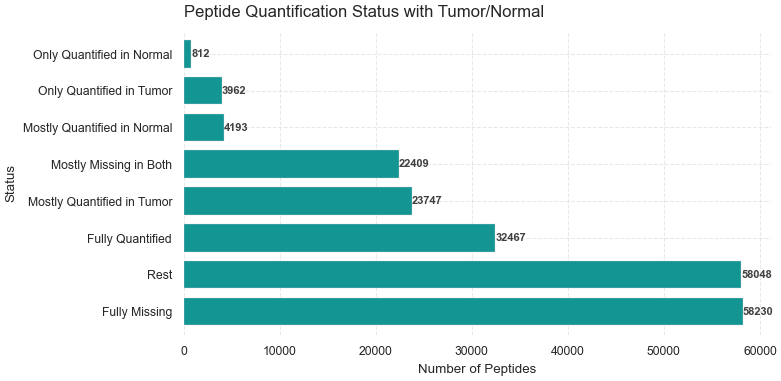

In [13]:
# Group the proteins based on the missingness percentage per group
mostlyQuant = 40
mostlyMiss = 60

missing_pct = pd.DataFrame(index = cleaned_data.index)
for k, v in new_status_dict.items():
    missing_pct[k] = cleaned_data[v].isna().sum(axis=1) / len(v) * 100

missing_pct["Status"] = "Rest"
missing_pct.loc[
    (missing_pct["Tumor"] == 0) & (missing_pct["Normal"] == 0), 
    "Status"
] = "Fully Quantified"
missing_pct.loc[
    (missing_pct["Tumor"] < mostlyQuant) & (missing_pct["Normal"] < mostlyQuant) & (missing_pct["Tumor"] > 0) & (missing_pct["Normal"] > 0), 
    "Status"
] = "Mostly Quantified in Both"
missing_pct.loc[
    (missing_pct["Tumor"] == 100) & (missing_pct["Normal"] == 100), 
    "Status"
] = "Fully Missing"
missing_pct.loc[
    (missing_pct["Tumor"] > mostlyMiss) & (missing_pct["Normal"] > mostlyMiss) & (missing_pct["Tumor"] < 100) & (missing_pct["Normal"] < 100), 
    "Status"
] = "Mostly Missing in Both"
missing_pct.loc[
    (missing_pct["Tumor"] < mostlyQuant) & (missing_pct["Normal"] > mostlyMiss), 
    "Status"
] = "Mostly Quantified in Tumor"
missing_pct.loc[
    (missing_pct["Tumor"] > mostlyMiss) & (missing_pct["Normal"] < mostlyQuant), 
    "Status"
] = "Mostly Quantified in Normal"
missing_pct.loc[
    (missing_pct["Tumor"] < mostlyMiss) & (missing_pct["Normal"] == 100), 
    "Status"
] = "Only Quantified in Tumor"
missing_pct.loc[
    (missing_pct["Tumor"] == 100) & (missing_pct["Normal"] < mostlyMiss), 
    "Status"
] = "Only Quantified in Normal"


# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

missing_pct.value_counts("Status").plot(
    ax=ax,
    kind="barh",
    color=[def_colors[0]],
    edgecolor="lightgrey",
    linewidth=0.25,
    width=0.75,
    # legend=False
)

# Add the counts on the end of the bars (barh)
for i, v in enumerate(missing_pct.value_counts("Status")):
    ax.text(v + 0.1, i, str(v), color="black", va="center", fontsize=8, fontweight="bold", alpha=0.75)


# Set the title and labels
ax.set_xlabel("Number of Peptides")
ax.set_ylabel("Status")
ax.set_title("Peptide Quantification Status with Tumor/Normal ", fontsize=12, loc="left", pad=10)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Cleaned_PairedSamples_GroupedQuantificationStatus_Barplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

Removing 80639 peptides from the dataset.

Number of unique proteins: 10701
Number of unique peptides: 123229


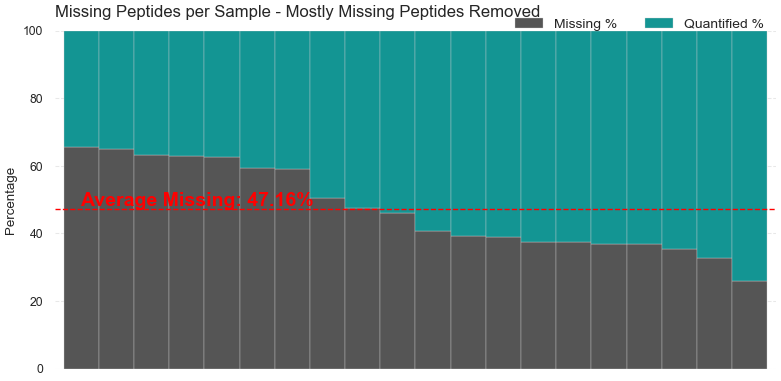

In [14]:
peptides_to_remove = missing_pct[missing_pct["Status"].isin(["Fully Missing", "Mostly Missing in Both"])].index
print(f"Removing {len(peptides_to_remove)} peptides from the dataset.")

# Remove the peptides from the dataset
info_subset = info_subset.drop(peptides_to_remove, axis=0).reset_index(drop=True)
quan_subset = cleaned_data.drop(peptides_to_remove, axis=0).reset_index(drop=True)
print()
print("Number of unique proteins:", info_subset["Protein"].nunique())
print("Number of unique peptides:", info_subset.shape[0])

plot_data = quan_subset.isna().sum(axis=0).sort_values(ascending=False).to_frame(name="Missing")
plot_data["Quantified"] = quan_subset.shape[0] - plot_data["Missing"]
plot_data["Total"] = quan_subset.shape[0]
plot_data["Missing %"] = plot_data["Missing"] / plot_data["Total"] * 100
plot_data["Quantified %"] = plot_data["Quantified"] / plot_data["Total"] * 100

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

plot_data[["Missing %", "Quantified %"]].plot(
    ax=ax, kind="bar", stacked=True, 
    color=[def_colors[4], def_colors[0]],
    edgecolor="lightgrey",
    linewidth=0.25,
    width=1,
    # legend=False
)
# Add line at average missing percentage
avg_missing = plot_data["Missing %"].mean()
ax.axhline(
    avg_missing,
    color="red",
    linestyle="--",
    linewidth=1,
    # label=f"Average Missing: {avg_missing:.2f}%"
)
#Text for the average missing percentage
ax.text(
    0, avg_missing + 1, f"Average Missing: {avg_missing:.2f}%", 
    color="red", fontsize=14, fontweight="bold"
)

# Set the title and labels
ax.set_ylim(0, 100)
ax.set_xlabel("")
# Remove xticks
ax.set_xticks([])
ax.set_ylabel("Percentage")
ax.set_title("Missing Peptides per Sample - Mostly Missing Peptides Removed", fontsize=12, loc="left", pad=10)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(loc="upper right", ncol=2, title_fontsize=12, fontsize=10, frameon=False, bbox_to_anchor=(1, 1.075))
sns.despine(left=True, bottom=True)
plt.tight_layout()

plots.save_figures(
    plt.gcf(),
    filename="Filter1_PairedSamples_SampleMissingness_StackedBarplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [15]:
minPepCnt = 4
# Check if all proteins have at least two peptides
tmp = info_subset["Protein"].value_counts() 
print("Number of proteins with at least four peptides:", tmp[tmp >= minPepCnt].shape[0])
print("Number of proteins with less than four peptide:", tmp[tmp < minPepCnt].shape[0])

# Filter the proteins with less than 3 peptides
subsetIdx = info_subset["Protein"].isin(tmp[tmp >= minPepCnt].index)

# Remove proteins with only less than three peptides
info_subset = info_subset[subsetIdx].reset_index(drop=True)

quan_subset = quan_subset[subsetIdx].reset_index(drop=True)

print()
print("Number of unique proteins:", info_subset["Protein"].nunique())
print("Number of unique peptides:", info_subset.shape[0])

Number of proteins with at least four peptides: 7491
Number of proteins with less than four peptide: 3210

Number of unique proteins: 7491
Number of unique peptides: 117290


## Imputation



### Low-value Imputation with Downshifted Values

#### Examine the Downshift and Percentile Selection for Data

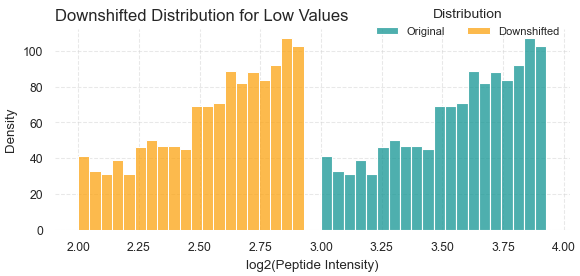

In [17]:
# Create a downshifted distribution to create random low-value replacement for the missing values
shiftMag = 1
lowPctl = 0.1
flatten_data = np.log2(quan_subset).values.flatten()
flatten_data = flatten_data[~np.isnan(flatten_data)]
lowVal = np.percentile(flatten_data, lowPctl)
lowDist = flatten_data[flatten_data < lowVal]
downshifted = lowDist - shiftMag

def find_downshift_mean(data, shiftMag=1, lowPctl=0.1):
    flatten_data = data.values.flatten()
    flatten_data = flatten_data[~np.isnan(flatten_data)]
    lowVal = np.percentile(flatten_data, lowPctl)
    lowDist = flatten_data[flatten_data < lowVal]
    downshifted = lowDist - shiftMag
    return downshifted.mean()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.histplot(lowDist, ax=ax, label="Original", color=def_colors[0], bins=20)
sns.histplot(downshifted, ax=ax, label="Downshifted", color=def_colors[1], bins=20)
# Set the title and labels
ax.set_xlabel("log2(Peptide Intensity)")
ax.set_ylabel("Density")
ax.set_title("Downshifted Distribution for Low Values", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(loc="upper right", title="Distribution", title_fontsize=10, fontsize=8, frameon=False, ncol=2, bbox_to_anchor=(1, 1.15))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="ImputeCheck_DownshiftedDistribution_Histogram",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

#### Impute Fully Missing Peptide per Group

In [18]:
shiftMag = 1
lowPctl = 0.1
print(f"Number of missing values in the dataset: {quan_subset.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {quan_subset.isna().sum().sum() / quan_subset.size * 100:.2f}%")
print()

print("Replacing downshifted-low values for fully missing peptides in a group:")
print("Parameters:")
print(f"  - Shift Magnitude: {shiftMag}")
print(f"  - Low Percentile: {lowPctl}")
print()

def find_downshift_mean(data, shiftMag=1, lowPctl=0.1):
    flatten_data = data.values.flatten()
    flatten_data = flatten_data[~np.isnan(flatten_data)]
    lowVal = np.percentile(flatten_data, lowPctl)
    lowDist = flatten_data[flatten_data < lowVal]
    downshifted = lowDist - shiftMag
    return downshifted.mean()
    
imputed_data = np.log2(quan_subset).copy()

# Imputation loop (Updated with vectorization)
for k, v in new_status_dict.items():
    isMiss = imputed_data[v].isna()
    fullMiss = isMiss.sum(axis=1) == len(v)

    # Calculate SDs from the full quantified samples for each column
    sd = imputed_data[v].dropna(how="all").std(axis=1)
    sdDist = np.random.choice(sd, size=fullMiss.sum(), replace=True)

    # Calculate downshifted means for all columns at once (vectorized)
    means = find_downshift_mean(imputed_data[v], shiftMag, lowPctl)

    # Impute missing values using the calculated means and SDs (vectorized)
    imputed_values = np.random.normal(means, sdDist[:, np.newaxis], (fullMiss.sum(), len(v)))
    # Clip the values to the shifted minimum
    imputed_values = np.clip(imputed_values, lowVal - shiftMag, None)
    imputed_data.loc[fullMiss, v] = imputed_values


imputed_data = imputed_data = 2 ** imputed_data

print(f"Number of missing values in the dataset: {imputed_data.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {imputed_data.isna().sum().sum() / imputed_data.size * 100:.2f}%")

Number of missing values in the dataset: 1082675
Pct of missing values in the dataset: 46.15%

Replacing downshifted-low values for fully missing peptides in a group:
Parameters:
  - Shift Magnitude: 1
  - Low Percentile: 0.1

Number of missing values in the dataset: 750165
Pct of missing values in the dataset: 31.98%


### Check the Data After Imputation

#### Distributions with Boxplot

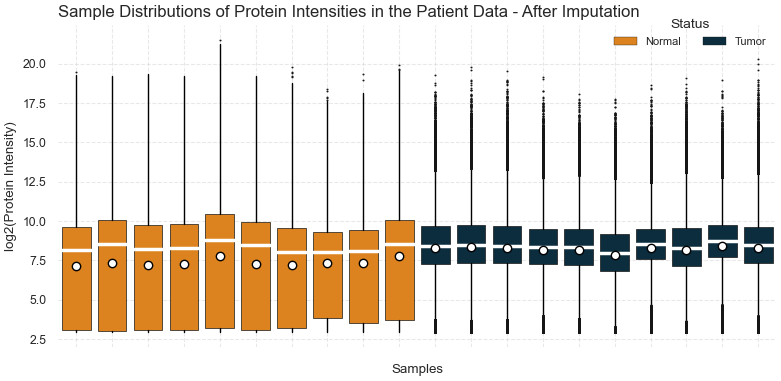

In [19]:
plot_data = np.log2(imputed_data).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    subset_to_run[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data - After Imputation", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Impute1_PairedSamples_StatusLabeled_DistributionBoxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

#### Distributions with Density Plot

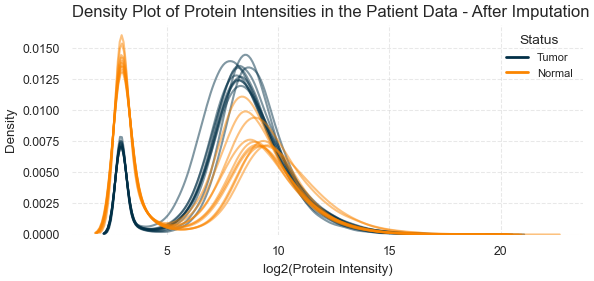

In [20]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(imputed_data),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Protein Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Protein Intensities in the Patient Data - After Imputation", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Impute1_PairedSamples_StatusLabeled_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

#### Missingness per Sample After Imputation

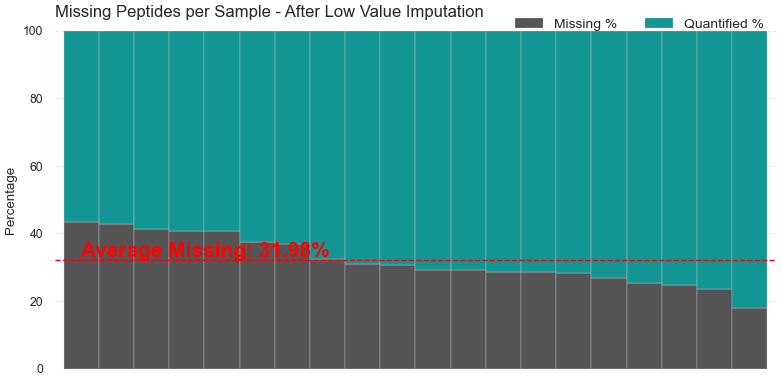

In [21]:
plot_data = imputed_data.isna().sum(axis=0).sort_values(ascending=False).to_frame(name="Missing")
plot_data["Quantified"] = imputed_data.shape[0] - plot_data["Missing"]
plot_data["Total"] = imputed_data.shape[0]
plot_data["Missing %"] = plot_data["Missing"] / plot_data["Total"] * 100
plot_data["Quantified %"] = plot_data["Quantified"] / plot_data["Total"] * 100

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

plot_data[["Missing %", "Quantified %"]].plot(
    ax=ax, kind="bar", stacked=True, 
    color=[def_colors[4], def_colors[0]],
    edgecolor="lightgrey",
    linewidth=0.25,
    width=1,
    # legend=False
)
# Add line at average missing percentage
avg_missing = plot_data["Missing %"].mean()
ax.axhline(
    avg_missing,
    color="red",
    linestyle="--",
    linewidth=1,
    # label=f"Average Missing: {avg_missing:.2f}%"
)
#Text for the average missing percentage
ax.text(
    0, avg_missing + 1, f"Average Missing: {avg_missing:.2f}%", 
    color="red", fontsize=15, fontweight="bold"
)

# Set the title and labels
ax.set_ylim(0, 100)
ax.set_xlabel("")
# Remove xticks
ax.set_xticks([])
ax.set_ylabel("Percentage")
ax.set_title("Missing Peptides per Sample - After Low Value Imputation", fontsize=12, loc="left", pad=10)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(loc="upper right", ncol=2, title_fontsize=12, fontsize=10, frameon=False, bbox_to_anchor=(1, 1.075))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Impute1_PairedSamples_SampleMissingness_StackedBarplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### KNN Imputation for the Rest of the Missing Values 

The rest of the missing values will be imputed with KNN imputation. This is to ensure that the missing values are imputed with the most similar samples. KNN is generally used for the missing values that doesn't have a pattern and it is a good imputation method after the initial imputation methods I've used.

In [22]:
knnTimer = utils.getTime()
totalMissing = imputed_data.isna().sum().sum()
# KNN Imputation for the remaining MAR values
print(f"Number of missing values in the dataset: {totalMissing}")
print(f"Pct of missing values in the dataset: {totalMissing / imputed_data.size * 100:.2f}%")
print()

print("Imputing the remaining MAR values with KNN imputation.")
print()
imputed_data_new = utils.knn_imputation(np.log2(imputed_data), n_neighbors=25)
imputed_data_new = 2 ** imputed_data_new

print(f"Number of missing values in the dataset: {imputed_data_new.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {imputed_data_new.isna().sum().sum() / imputed_data_new.size * 100:.2f}%")
print()

print(f"kNN Execution Time for {totalMissing} missing values:", utils.prettyTimer(utils.getTime() - knnTimer))

Number of missing values in the dataset: 750165
Pct of missing values in the dataset: 31.98%

Imputing the remaining MAR values with KNN imputation.

Number of missing values in the dataset: 0
Pct of missing values in the dataset: 0.00%

kNN Execution Time for 750165 missing values: 00h:22m:01s


### Check the Data After KNN Imputation

#### Distributions with Boxplot

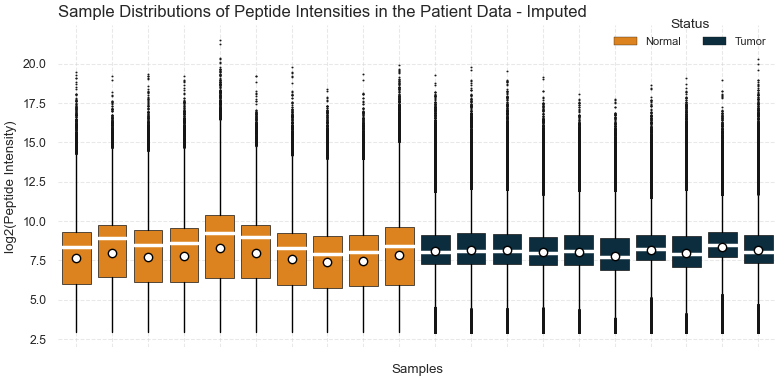

In [23]:
plot_data = np.log2(imputed_data_new).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    subset_to_run[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Peptide Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Peptide Intensities in the Patient Data - Imputed", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Impute2_PairedSamples_StatusLabeled_DistributionBoxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

#### Distributions with Density Plot

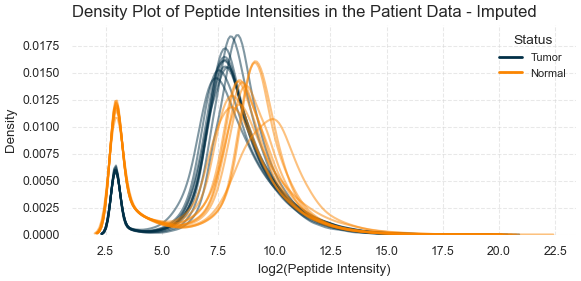

In [24]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(imputed_data_new),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Peptide Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Peptide Intensities in the Patient Data - Imputed", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Impute2_PairedSamples_StatusLabeled_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Normalization 

The normalization of this data is also requires a special attention. Because the computational proteoform identification analysis will be done by looking at the peptide intensity levels between groups as well as within the host protein the normalization will be done by centering the peptide intensity levels by the median of the peptide and adjusting the intensity levels against the normal samples.

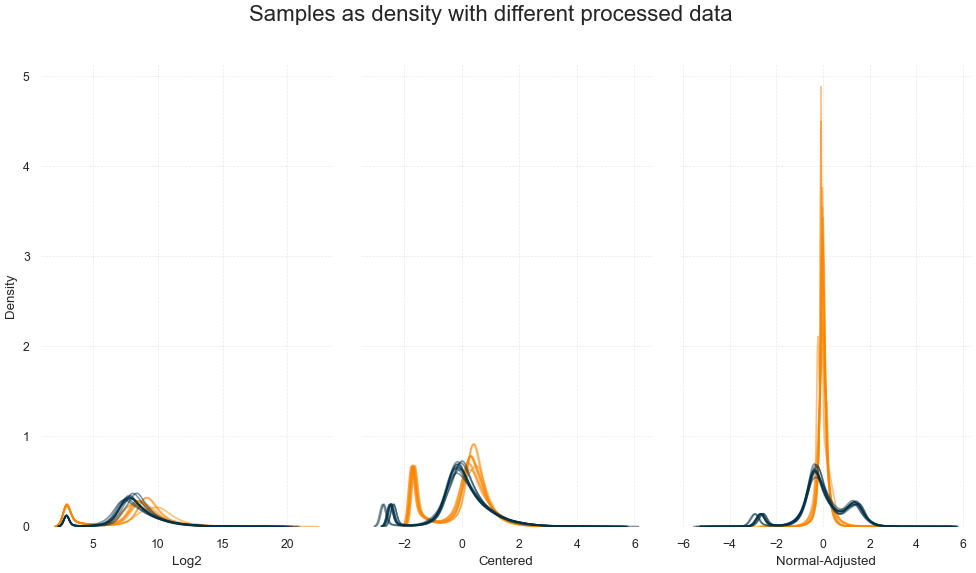

In [25]:
# Standardize each group of columns
# Scale data to 0 mean and 1 variance
tmp = np.log2(imputed_data_new)
centered_data = (tmp - tmp.mean()) / tmp.std()

# Adjusted data
# Calculate the mean of each peptide across the Normal samples
cntrPepMean = centered_data[subset_to_run_dict["Normal"]].mean(axis=1)
# Substract cntrPepMean from each sample row-wise in centered_data
adjusted_dat = centered_data.subtract(cntrPepMean, axis=0)

## Visualize the log2, centered and adjusted data densities with 3 subplots 1x3
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True,gridspec_kw={"wspace": 0.1})
for i, cur_data, cur_title in zip(
    range(3), 
    [tmp, centered_data, adjusted_dat], 
    ["Log2", "Centered", "Normal-Adjusted"]
):
    for c in cur_data.columns:
        sns.kdeplot(
            data=cur_data[c].dropna(), 
            ax=axs[i], 
            fill=False, 
            alpha=0.5, 
            color=sample_colors[c]
        )

    # axs[i].set_title(cur_title)
    axs[i].set_xlabel(cur_title)
    axs[i].set_ylabel("Density")
    axs[i].grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")    
    # axs[i].legend(title="Group", loc="upper left")

fig.suptitle("Samples as density with different processed data", fontsize=16)
sns.despine(fig, top=True, right=True, left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Normalization1_PairedSamples_ProcessedData_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

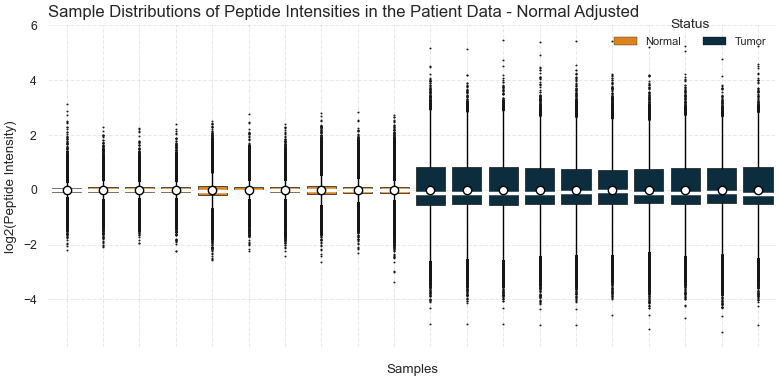

In [26]:
plot_data = adjusted_dat.melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    subset_to_run[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Peptide Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Peptide Intensities in the Patient Data - Normal Adjusted", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Normalization1_PairedSamples_StatusLabeled_DistributionBoxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

# Look At the Proteins & Peptides

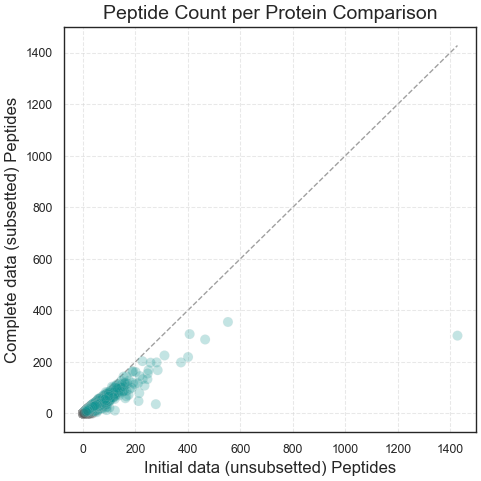

In [27]:
info_subset.groupby("Protein").size()
# Initialize PeptideID for easy setup later on
info_subset['PeptideID'] = info_subset.groupby('Protein').cumcount() + 1
protein_info["nPeps_cleaned"] = info_subset.groupby("Protein").size()
protein_info["nPeps_cleaned"].fillna(0, inplace=True)
protein_info["inData"] = protein_info["nPeps_cleaned"] > 0
protein_info["nPeps_cleaned"] = protein_info["nPeps_cleaned"].astype(int)

# Figure for comparing how nPeps changed
fig, ax = plt.subplots(
    figsize=(5, 5)
)

# Scatter plot for the number of peptides
protein_info.plot(
    x="nPeps_init",
    y="nPeps_cleaned",
    kind="scatter",
    ax=ax,
    # color=def_colors[0],
    edgecolor="lightgrey",
    linewidth=0.25,
    alpha=0.25,
    s=50,
    c=protein_info["inData"].map({True: def_colors[0], False: def_colors[4]}),
    legend=True,
)
# draw the diagonal line
ax.plot(
    [0, protein_info["nPeps_init"].max()], 
    [0, protein_info["nPeps_init"].max()], 
    color="grey", linestyle="--", linewidth=1, 
    label="y=x", alpha=0.75, zorder=0
)

# Set the title and labels
ax.set_xlabel("Initial data (unsubsetted) Peptides", fontsize=12)
ax.set_ylabel("Complete data (subsetted) Peptides", fontsize=12)
ax.set_title("Peptide Count per Protein Comparison", fontsize=14)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
plt.tight_layout()

# Save the Processed Tables

## Build the Test Data

In [28]:
## Data for the next steps and their importance
# info_subset -> The analyte info dataframe the order same as others
# cleaned_data -> With missing values
# imputed_data -> Biological absence imputed
# imputed_data_new -> Sparse missing values imputed with kNN
# adjusted_dat -> Normalized data

### Quantitative Values
test_data = imputed_data_new.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)
test_data['log10(Intensity)'] = np.log10(test_data['Intensity'])
test_data['adjIntensity'] = adjusted_dat.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)['Intensity']

### Missingness and Imputation Flags (for Weighting)
# Add flags for missingness and imputation
test_data['isReal'] = cleaned_data.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)['Intensity'].notna()
test_data['isImputed'] = 1 - test_data['isReal']
test_data['sparseMiss'] = imputed_data.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)['Intensity'].isna()
# Complete missingness flag (Biological Absence)
test_data['isCompMiss'] = test_data['isImputed'] & (~test_data['sparseMiss']) 
# Add Condition column for grouping
test_data.insert(1, "Condition", test_data["Sample"].map(unique_group_dict))

# Add Protein, Peptide, and PeptideID columns
test_data = test_data.merge(
    info_subset[["Protein", "Peptide", "PeptideID"]],
    left_on="index",
    right_index=True,
    how="left"
)
test_data = test_data.drop(columns=['isImputed', 'sparseMiss', 'index'])

### Build Weight Logic

# Useful for ensuring the values are between 0 and 1
def min_max_scale(x): return (x - x.min()) / (x.max() - x.min())

## The Imputation Values (Real, Sparse, Complete)
value_def = {"Real": 1, "Sparse": 10**-5, "Complete": .75}
test_data['imputeW'] = np.where(
    test_data['isReal'] == 1, value_def["Real"], 
    np.where(
        test_data['isCompMiss'] == 1, 
        value_def["Complete"], 
        value_def["Sparse"]
    )
)
## Technical Replicate Variance (1 = Low, 0 = High)
# Calculate tec variance per protein-peptide-condition
test_data['TechVarW'] = test_data.groupby([ 
    'Protein', 'Peptide', 'Condition'
])['log10(Intensity)'].transform('var')
# Min-max scaling of the technical variance and inverse
test_data['TechVarW'] = 1 - min_max_scale(test_data['TechVarW'])

## Combine the weights higher importance to imputation
test_data['Weight'] = min_max_scale(
    (test_data['imputeW'] * 0.90) +
    (test_data['TechVarW'] * 0.10)
)

# Reorder the columns
test_data = test_data[[
    "Protein", "Peptide", "PeptideID", "Sample", 
    "Condition", "Intensity", "log10(Intensity)",
    "adjIntensity", "isReal", "isCompMiss", 
    "imputeW", "TechVarW", "Weight"
]]
test_data.head()

,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717


## Save the Processed Data

### Test Data

In [29]:
# Save the test data to a feather file
print(f"Saving the test data to {output_path}MatchedPatient_TumorNormal_PeptideLevel_TestData.feather")
utils.print_shape(test_data, "Test (long-format)")
feather.write_dataframe(test_data, f"{output_path}MatchedPatient_TumorNormal_PeptideLevel_TestData.feather")
test_data.head()

Saving the test data to ./data/processed/MatchedPatient_TumorNormal_PeptideLevel_TestData.feather
Test (long-format) data has 2,345,800 rows and 13 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717


### Peptide Level Information Data

In [30]:
# Save the Peptide information to a feather file
print(f"Saving the peptide information to {output_path}MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather")
utils.print_shape(info_subset, "Peptide Info")
feather.write_dataframe(info_subset, f"{output_path}MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather")
info_subset.head()

Saving the peptide information to ./data/processed/MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather
Peptide Info data has 117,290 rows and 11 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5


## Metadata

In [31]:
# Save the subset metadata to a feather file
print(f"Saving the subset metadata to {output_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(subset_to_run, "Subset Metadata")
feather.write_dataframe(subset_to_run, f"{output_path}MatchedPatient_TumorNormal_Metadata.feather")
subset_to_run.head()

Saving the subset metadata to ./data/processed/MatchedPatient_TumorNormal_Metadata.feather
Subset Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,NaN,NaN,NaN,NaN,AG,NaN,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,NaN,NaN,NaN,NaN,AG,NaN,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,NaN,NaN,NaN,NaN,AG,NaN,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,NaN,NaN,NaN,NaN,AG,NaN,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,NaN,NaN,NaN,NaN,AG,NaN,True


## Uniprot Annotation Data

In [32]:
# Process the uniprot file
uniprot_df = utils.preprocess_uniprot(
    "./data/input/uniprotkb_taxonomy_id_2759_AND_model_or_2024_05_25.txt"
)
# Subset the uniprot data to the proteins in the info_subset
uniprot_df = uniprot_df[uniprot_df["protein_id"].isin(info_subset["Protein"].unique())]

print(f"Saving the uniprot annotation data to {output_path}Uniprot_Annotation.feather")
utils.print_shape(uniprot_df, "Uniprot Data")
feather.write_dataframe(uniprot_df, f"{output_path}Uniprot_Annotation.feather")
uniprot_df.head()

Saving the uniprot annotation data to ./data/processed/Uniprot_Annotation.feather
Uniprot Data data has 370,812 rows and 6 columns


,protein_id,feature,isoform_id,start,end,note
941,A0AV96,CHAIN,,1.0000,593.0000,RNA-binding protein 47
942,A0AV96,DOMAIN,,71.0000,149.0000,RRM 1
943,A0AV96,DOMAIN,,151.0000,233.0000,RRM 2
944,A0AV96,DOMAIN,,246.0000,318.0000,RRM 3
945,A0AV96,REGION,,1.0000,25.0000,Disordered


# Conclusion

WIP

In [33]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:28m:31s
